# # Model Building and Training

# ## 1. Setup and Data Loading

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score, 
                           precision_score, recall_score, accuracy_score,
                           confusion_matrix, classification_report,
                           precision_recall_curve, roc_curve)

# Additional imports
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Model Building - Setup Complete")

# %%
# Load processed data
print("Loading processed data...")

try:
    fraud_data = pd.read_csv('data/processed/fraud_data_processed.csv')
    creditcard_data = pd.read_csv('data/processed/creditcard_data_processed.csv')
    
    print(f"Fraud Data Shape: {fraud_data.shape}")
    print(f"Credit Card Data Shape: {creditcard_data.shape}")
    
    # Display sample
    print("\nFraud Data Sample:")
    display(fraud_data.head())
    
    print("\nCredit Card Data Sample:")
    display(creditcard_data.head())
    
except FileNotFoundError:
    print("Processed data not found. Please run feature-engineering.ipynb first.")
    raise

Model Building - Setup Complete
Loading processed data...
Fraud Data Shape: (151112, 64)
Credit Card Data Shape: (284807, 90)

Fraud Data Sample:


,user_id,signup_time,purchase_time,purchase_value,age,ip_address,purchase_hour,purchase_day,purchase_dayofmonth,purchase_month,signup_hour,signup_day,is_weekend,is_night,is_business_hours,time_since_signup,same_day_signup,within_1h_signup,within_24h_signup,hour_diff_signup_purchase,user_transaction_count,device_transaction_count,device_uniqueness,purchase_value_log,high_value_flag,low_value_flag,medium_value_flag,young_adult,middle_aged,senior,browser_risk_score,source_risk_score,browser_popularity,country_risk_score,high_risk_combo,rapid_high_value,night_high_value,user_avg_value,user_value_std,user_total_transactions,user_avg_time_since_signup,user_first_time_since_signup,device_avg_value,device_total_transactions,device_unique_users,composite_risk_score,device_id_freq,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,purchase_category_2,purchase_category_3,purchase_category_4,purchase_category_5,age_group_18-25,age_group_26-35,age_group_36-50,age_group_51-65,age_group_65+,class
0,-1.5439,2015-02-24 22:55:49,2015-04-18 02:47:11,-0.0370,0.6799,-1.1369,2,5,18,4,22,1,1.5687,1.2939,-0.7787,-0.0769,-0.2396,-0.2308,-0.2480,20,0.0000,-0.2615,0.3649,-0.0363,0.0000,0.0000,0.0000,-0.5138,1.2626,-0.0447,1.0287,-0.7222,1.1313,-0.0000,0.0000,0.0000,0.0000,-0.0370,0.0000,0.0000,-0.0769,-0.0769,-0.0400,-0.2615,-0.2615,6.3561,-0.2615,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False,False,0
1,1.1541,2015-06-07 20:39:50,2015-06-08 01:38:54,-0.7037,2.3045,-1.4432,1,0,8,6,20,6,-0.6375,1.2939,-0.7787,-0.8993,-0.2396,-0.2308,4.0316,19,0.0000,-0.2615,0.3649,-0.9662,0.0000,0.0000,-1.0000,-0.5138,-0.7920,-0.0447,1.0287,-0.2616,1.1313,-0.0000,0.0000,0.0000,0.0000,-0.7037,0.0000,0.0000,-0.8993,-0.8993,-0.7600,-0.2615,-0.2615,6.3926,-0.2615,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0
2,-1.7233,2015-01-01 18:52:44,2015-01-01 18:52:45,-0.7407,2.3045,0.3759,18,3,1,1,18,3,-0.6375,-0.7729,-0.7787,-0.9026,4.1736,4.3332,4.0316,0,0.0000,3.9419,-3.4768,-1.0443,0.0000,0.0000,-1.0000,-0.5138,-0.7920,-0.0447,-0.8832,-0.7222,-2.2354,-0.0000,0.0000,0.0000,0.0000,-0.7407,0.0000,0.0000,-0.9026,-0.9026,-0.8000,3.9419,3.9419,9.5132,3.9419,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,1
3,-0.4341,2015-04-28 21:13:25,2015-05-04 13:54:50,0.3333,0.9120,1.3523,13,0,4,5,21,1,-0.6375,-0.7729,1.2842,-0.8125,-0.2396,-0.2308,-0.2480,8,0.0000,-0.2615,0.3649,0.2874,0.0000,0.0000,0.0000,-0.5138,1.2626,-0.0447,-0.6885,-0.7222,-1.0118,-0.0000,0.0000,0.0000,0.0000,0.3333,0.0000,0.0000,-0.8125,-0.8125,0.3600,-0.2615,-0.2615,-0.3222,-0.2615,False,True,False,False,False,True,True,False,False,True,False,False,False,True,False,False,0
4,0.1837,2015-07-21 07:09:52,2015-09-09 18:40:53,0.1481,1.3762,-1.3909,18,2,9,9,7,1,-0.6375,-0.7729,-0.7787,-0.1035,-0.2396,-0.2308,-0.2480,11,0.0000,-0.2615,0.3649,0.1357,0.0000,0.0000,0.0000,-0.5138,1.2626,-0.0447,-0.6885,-0.2616,-1.0118,-0.0000,0.0000,0.0000,0.0000,0.1481,0.0000,0.0000,-0.1035,-0.1035,0.1600,-0.2615,-0.2615,-0.2857,-0.2615,False,False,False,False,False,True,True,False,True,False,False,False,False,True,False,False,0



Credit Card Data Sample:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,transaction_hour,transaction_day_hour,transaction_minute,is_night,is_business_hours,is_weekend_hour,hour_of_day_sin,hour_of_day_cos,amount_log,amount_sqrt,amount_scaled,amount_robust,high_amount_flag,low_amount_flag,time_since_last,time_since_last_log,rapid_transaction,long_gap,amount_rolling_mean,amount_rolling_std,amount_rolling_zscore,time_gap_rolling_mean,V17_V14_interaction,V17_V14_ratio,V17_V12_interaction,V17_V12_ratio,V17_V10_interaction,V17_V10_ratio,V17_V16_interaction,V17_V16_ratio,V14_V12_interaction,V14_V12_ratio,V14_V10_interaction,V14_V10_ratio,V14_V16_interaction,V14_V16_ratio,V12_V10_interaction,V12_V10_ratio,V12_V16_interaction,V12_V16_ratio,V10_V16_interaction,V10_V16_ratio,pca_positive_sum,pca_negative_sum,pca_abs_sum,mahalanobis_distance,pca_magnitude,distance_to_fraud_centroid,V17_rolling_skew,V17_rolling_kurtosis,V14_rolling_skew,V14_rolling_kurtosis,V12_rolling_skew,V12_rolling_kurtosis,heuristic_risk_score,amount_category_2,amount_category_3,amount_category_4,amount_category_5,Class
0,-0.9950,-0.6942,-0.0441,1.6728,0.9734,-0.2451,0.3471,0.1937,0.0826,0.3311,0.0834,-0.5404,-0.6183,-0.9961,-0.3246,1.6040,-0.5368,0.2449,0.0308,0.4963,0.3261,-0.0249,0.3829,-0.1769,0.1105,0.2466,-0.3922,0.3309,-0.0638,1.7833,-2.4069,-1.9603,-1.9960,2.0577,-1.0236,0.0000,0.3757,1.6833,0.7603,1.1921,1.7833,1.7833,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.6686,-0.0656,2.0372,4.1014,-0.0132,-0.0018,-0.0243,-0.0018,0.0037,0.0023,-0.0240,-0.0001,0.0452,0.0017,-0.0069,-0.0028,0.0486,0.0015,-0.0136,-0.0028,0.0897,0.0061,-0.0137,0.0007,-0.2456,0.6203,-0.5336,-0.7340,-0.7323,-0.8203,-0.1378,-0.5064,0.8227,-0.5412,0.0975,-0.4261,0.0676,False,False,False,True,0
1,-0.9950,0.6085,0.1612,0.1098,0.3165,0.0435,-0.0618,-0.0637,0.0713,-0.2325,-0.1533,1.5800,1.0661,0.4914,-0.1500,0.6944,0.5294,-0.1352,-0.2188,-0.1791,-0.0896,-0.3074,-0.8801,0.1622,-0.5611,0.3207,0.2611,-0.0223,0.0446,-0.2698,-2.4069,-1.9603,-1.9960,2.0577,-1.0236,0.0000,0.3757,1.6833,-0.7403,-0.4584,-0.2698,-0.2698,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.6730,-0.0678,-0.1283,4.0802,0.0034,-0.0010,-0.0231,-0.0018,0.0038,0.0018,-0.0131,0.0002,-0.0360,0.0016,0.0059,-0.0020,-0.0222,0.0001,-0.0430,-0.0027,0.1526,0.0114,-0.0249,0.0005,-0.5376,1.0110,-0.9299,-0.4973,-0.4691,0.4639,-0.1535,-0.5044,0.8451,-0.5381,0.0961,-0.4260,0.0947,False,False,False,False,0
2,-0.9950,-0.6935,-0.8116,1.1695,0.2682,-0.3646,1.3515,0.6398,0.2074,-1.3787,0.1907,0.6118,0.0661,0.7207,-0.1731,2.5629,-3.2982,1.3069,-0.1448,-2.7786,0.6810,0.3376,1.0634,1.4563,-1.1381,-0.6285,-0.2884,-0.1371,-0.1810,4.9837,-2.4069,-1.9603,-1.9960,2.0577,-1.0236,0.0000,0.3757,1.6833,1.1343,2.3420,4.9837,4.9837,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,-0.6774,-0.0700,5.4269,4.0878,-0.0375,-0.0052,0.0139,0.0008,0.0453,0.0031,-0.7864,-0.0000,-0.0026,0.0011,-0.0084,-0.0023,0.1593,0.0007,0.0033,-0.0000,-0.0590,-0.0012,-0.1932,0.0009,0.7861,-0.3382,0.5770,1.3558,1.1031,-0.1399,-0.1613,-0.5004,0.8632,-0.5324,0.1323,-0.4289,3.9214,False,False,False,True,0
3,-0.9950,-0.4933,-0.1122,1.1825,-0.6097,-0.0075,0.9361,0.1921,0.3160,-1.2625,-0.0505,-0.2219,0.1784,0.5102,-0.3004,-0.6898,-1.2093,-0.8054,2.3453,-1.5142,-0.2699,-0.1474,0.0073,-0.3048,-1.9410,1.2419,-0.4602,0.1554,0.1862,1.4183,-2.4069,-1.9603,-1.9960,2.0577,-1.0236,0.0000,0.3757,1.6833,0.6832,1.0144,1.4183,1.4183,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.6797,-0.0723,1.6594,4.0666,0.0401,-0.0001,-0.0231,-0.0023,0.0074,0.0050,0.1777,0.0014,-0.0121,0.0013,0.0039,-0.0011,0.1013,0.0010,-0.0024,-0.0014,-0.0583,-0.0020,0.0187,0.0011,-0.4928,-0.0475,-0.1835,-0.2770,-0.3717,-1.2128,-0.1796,-0.5118,0.8392,-0.5329,0.1686,-0.4320,0.1165,False,False,False,True,0
4,-0.9950,-0.5913,0.5315,1.0214,0.2847,-0.2950,0.0720,0.4793,-0.2265,0.7443,0.6916,-0.8061,0.5386,1.3522,-1.1680,0.1913,-0.5152,-0.2791,-0.0456,0.9870,0.5299,-0.0128,1.1000,-0.2201,0.2333,-0.3952,1.0416,0.5436

# ## 2. Evaluation Metrics and Utilities

In [42]:
def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="", dataset_name=""):
    """Comprehensive model evaluation"""
    results = {}
    
    # Basic metrics
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['precision'] = precision_score(y_true, y_pred, zero_division=0)
    results['recall'] = recall_score(y_true, y_pred, zero_division=0)
    results['f1_score'] = f1_score(y_true, y_pred, zero_division=0)
    
    # Probability-based metrics
    if y_pred_proba is not None:
        results['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
        results['pr_auc'] = average_precision_score(y_true, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    results['confusion_matrix'] = cm
    results['tn'], results['fp'], results['fn'], results['tp'] = cm.ravel()
    
    # Business metrics
    results['false_positive_rate'] = results['fp'] / (results['fp'] + results['tn']) if (results['fp'] + results['tn']) > 0 else 0
    results['false_negative_rate'] = results['fn'] / (results['fn'] + results['tp']) if (results['fn'] + results['tp']) > 0 else 0
    
    # Cost analysis
    fp_cost = 1  # Customer friction
    fn_cost = 10  # Missed fraud
    results['total_cost'] = (results['fp'] * fp_cost) + (results['fn'] * fn_cost)
    results['cost_per_transaction'] = results['total_cost'] / len(y_true)
    
    # Create detailed report
    print(f"\n{'='*60}")
    print(f"EVALUATION: {model_name} - {dataset_name}")
    print(f"{'='*60}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Legitimate', 'Fraud']))
    
    print(f"Accuracy:   {results['accuracy']:.4f}")
    print(f"Precision:  {results['precision']:.4f}")
    print(f"Recall:     {results['recall']:.4f}")
    print(f"F1-Score:   {results['f1_score']:.4f}")
    
    if y_pred_proba is not None:
        print(f"ROC-AUC:    {results['roc_auc']:.4f}")
        print(f"PR-AUC:     {results['pr_auc']:.4f}")
    
    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"                Neg    Pos")
    print(f"  Actual Neg   {results['tn']:5d}   {results['fp']:5d}")
    print(f"          Pos   {results['fn']:5d}   {results['tp']:5d}")
    
    print(f"\nBusiness Metrics:")
    print(f"  False Positive Rate: {results['false_positive_rate']:.4f}")
    print(f"  False Negative Rate: {results['false_negative_rate']:.4f}")
    print(f"  Total Cost (FP=1, FN=10): {results['total_cost']:.0f}")
    
    return results

def plot_model_comparison(results_dict, dataset_name):
    """Plot comparison of multiple models"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    models = list(results_dict.keys())
    
    # Metrics to plot
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'pr_auc']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
    
    for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
        ax = axes[idx // 3, idx % 3]
        values = [results_dict[model].get(metric, 0) for model in models]
        
        bars = ax.bar(range(len(models)), values)
        ax.set_title(f'{name}')
        ax.set_xlabel('Models')
        ax.set_ylabel(name)
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.set_ylim(0, 1)
        
        # Add value labels
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')
    
    plt.suptitle(f'Model Comparison - {dataset_name}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f'plots/model_comparison_{dataset_name.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_pr_curves(models_dict, X_test, y_test, dataset_name):
    """Plot ROC and Precision-Recall curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROC Curve
    ax = axes[0]
    ax.plot([0, 1], [0, 1], 'k--', label='Random')
    
    for model_name, model in models_dict.items():
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            ax.plot(fpr, tpr, label=f'{model_name} (AUC={auc_score:.3f})')
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    ax = axes[1]
    baseline = y_test.mean()
    ax.plot([0, 1], [baseline, baseline], 'k--', label=f'Baseline ({baseline:.3f})')
    
    for model_name, model in models_dict.items():
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_auc = average_precision_score(y_test, y_pred_proba)
            ax.plot(recall, precision, label=f'{model_name} (AUC={pr_auc:.3f})')
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curves')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Performance Curves - {dataset_name}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'plots/roc_pr_curves_{dataset_name.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()


## Date Time Column 

In [21]:


# Convert to datetime
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# Feature engineering
fraud_data['time_to_purchase_seconds'] = (
    fraud_data['purchase_time'] - fraud_data['signup_time']
).dt.total_seconds()

fraud_data['purchase_hour'] = fraud_data['purchase_time'].dt.hour
fraud_data['purchase_dayofweek'] = fraud_data['purchase_time'].dt.dayofweek

# Drop original datetime columns
fraud_data.drop(columns=['signup_time', 'purchase_time'], inplace=True)


# ## 3. Data Preparation and Split

In [22]:
def prepare_data_splits(X, y, dataset_name, test_size=0.2, apply_smote=True):
    """Prepare data splits with optional SMOTE"""
    print(f"\nPreparing data splits for {dataset_name}...")
    
    # Stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=42,
        stratify=y
    )
    
    print(f"  Original class distribution:")
    print(f"    Train: {len(X_train)} samples")
    train_counts = y_train.value_counts()
    print(f"      Legitimate: {train_counts[0]} ({train_counts[0]/len(y_train)*100:.2f}%)")
    print(f"      Fraud: {train_counts[1]} ({train_counts[1]/len(y_train)*100:.2f}%)")
    
    print(f"    Test: {len(X_test)} samples")
    test_counts = y_test.value_counts()
    print(f"      Legitimate: {test_counts[0]} ({test_counts[0]/len(y_test)*100:.2f}%)")
    print(f"      Fraud: {test_counts[1]} ({test_counts[1]/len(y_test)*100:.2f}%)")
    
    # Apply SMOTE if requested
    if apply_smote:
        print(f"\n  Applying SMOTE to training data...")
        smote = SMOTE(sampling_strategy=0.33, random_state=42, k_neighbors=5)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        resampled_counts = y_train_resampled.value_counts()
        print(f"    After SMOTE:")
        print(f"      Legitimate: {resampled_counts[0]} ({resampled_counts[0]/len(y_train_resampled)*100:.2f}%)")
        print(f"      Fraud: {resampled_counts[1]} ({resampled_counts[1]/len(y_train_resampled)*100:.2f}%)")
        
        return X_train, X_test, y_train, y_test, X_train_resampled, y_train_resampled
    
    return X_train, X_test, y_train, y_test

# Prepare data for both datasets
print("="*80)
print("DATA PREPARATION")
print("="*80)

# For fraud data
X_fraud = fraud_data.drop(columns=['class'])
y_fraud = fraud_data['class']

fraud_splits = prepare_data_splits(X_fraud, y_fraud, "E-commerce Fraud", apply_smote=True)
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, X_fraud_train_smote, y_fraud_train_smote = fraud_splits

# For credit card data
X_credit = creditcard_data.drop(columns=['Class'])
y_credit = creditcard_data['Class']

credit_splits = prepare_data_splits(X_credit, y_credit, "Credit Card Fraud", apply_smote=True)
X_credit_train, X_credit_test, y_credit_train, y_credit_test, X_credit_train_smote, y_credit_train_smote = credit_splits

DATA PREPARATION

Preparing data splits for E-commerce Fraud...
  Original class distribution:
    Train: 120889 samples
      Legitimate: 109568 (90.64%)
      Fraud: 11321 (9.36%)
    Test: 30223 samples
      Legitimate: 27393 (90.64%)
      Fraud: 2830 (9.36%)

  Applying SMOTE to training data...
    After SMOTE:
      Legitimate: 109568 (75.19%)
      Fraud: 36157 (24.81%)

Preparing data splits for Credit Card Fraud...
  Original class distribution:
    Train: 227845 samples
      Legitimate: 227451 (99.83%)
      Fraud: 394 (0.17%)
    Test: 56962 samples
      Legitimate: 56864 (99.83%)
      Fraud: 98 (0.17%)

  Applying SMOTE to training data...
    After SMOTE:
      Legitimate: 227451 (75.19%)
      Fraud: 75058 (24.81%)


# ## 4. Baseline Model: Logistic Regression

In [23]:
def train_logistic_regression(X_train, y_train, X_test, y_test, dataset_name, use_smote=True):
    """Train and evaluate Logistic Regression"""
    print(f"\n{'='*80}")
    print(f"LOGISTIC REGRESSION - {dataset_name}")
    print(f"{'='*80}")
    
    # Choose training data
    if use_smote and dataset_name == "E-commerce Fraud":
        X_train_use = X_fraud_train_smote
        y_train_use = y_fraud_train_smote
    elif use_smote and dataset_name == "Credit Card Fraud":
        X_train_use = X_credit_train_smote
        y_train_use = y_credit_train_smote
    else:
        X_train_use = X_train
        y_train_use = y_train
    
    # Initialize model
    lr_model = LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        solver='lbfgs',
        C=1.0,
        n_jobs=-1
    )
    
    # Cross-validation
    print("\nCross-validation results:")
    cv_scores = cross_val_score(
        lr_model, X_train_use, y_train_use,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1
    )
    
    print(f"  ROC-AUC Scores: {cv_scores}")
    print(f"  Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    # Train model
    print("\nTraining model...")
    lr_model.fit(X_train_use, y_train_use)
    
    # Predictions
    y_pred = lr_model.predict(X_test)
    y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
    
    # Evaluate
    results = evaluate_model(y_test, y_pred, y_pred_proba, 
                           "Logistic Regression", dataset_name)
    
    # Feature coefficients
    if hasattr(lr_model, 'coef_'):
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'coefficient': lr_model.coef_[0]
        }).sort_values('coefficient', key=abs, ascending=False).head(10)
        
        print(f"\nTop 10 Features by Coefficient Magnitude:")
        print(feature_importance.to_string(index=False))
    
    return lr_model, results

print("="*80)
print("TRAINING LOGISTIC REGRESSION MODELS")
print("="*80)

# Train for fraud data
lr_fraud_model, lr_fraud_results = train_logistic_regression(
    X_fraud_train, y_fraud_train, X_fraud_test, y_fraud_test,
    "E-commerce Fraud", use_smote=True
)

# Train for credit card data
lr_credit_model, lr_credit_results = train_logistic_regression(
    X_credit_train, y_credit_train, X_credit_test, y_credit_test,
    "Credit Card Fraud", use_smote=True
)

TRAINING LOGISTIC REGRESSION MODELS

LOGISTIC REGRESSION - E-commerce Fraud

Cross-validation results:
  ROC-AUC Scores: [0.91446663 0.92342335 0.90311599 0.90501177 0.90981861]
  Mean: 0.9112 (+/- 0.0146)

Training model...

EVALUATION: Logistic Regression - E-commerce Fraud

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.97      0.92      0.95     27393
       Fraud       0.49      0.72      0.58      2830

    accuracy                           0.90     30223
   macro avg       0.73      0.82      0.77     30223
weighted avg       0.92      0.90      0.91     30223

Accuracy:   0.9047
Precision:  0.4939
Recall:     0.7166
F1-Score:   0.5848
ROC-AUC:    0.8355
PR-AUC:     0.6945

Confusion Matrix:
                Predicted
                Neg    Pos
  Actual Neg   25315    2078
          Pos     802    2028

Business Metrics:
  False Positive Rate: 0.0759
  False Negative Rate: 0.2834
  Total Cost (FP=1, FN=10): 10098

Top 10 Featur

# ## 5. Ensemble Model: Random Forest

TRAINING RANDOM FOREST MODELS

RANDOM FOREST - E-commerce Fraud

Hyperparameter tuning with Grid Search...
  Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
  Best CV score: 0.9569

EVALUATION: Random Forest - E-commerce Fraud

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.95      1.00      0.98     27393
       Fraud       0.97      0.54      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.96      0.77      0.83     30223
weighted avg       0.96      0.96      0.95     30223

Accuracy:   0.9551
Precision:  0.9718
Recall:     0.5357
F1-Score:   0.6907
ROC-AUC:    0.8434
PR-AUC:     0.7144

Confusion Matrix:
                Predicted
                Neg    Pos
  Actual Neg   27349      44
          Pos    1314    1516

Business Metrics:
  False Positive Rate: 0.0016
  False Negative Rate: 0.4643
  Total Cost 

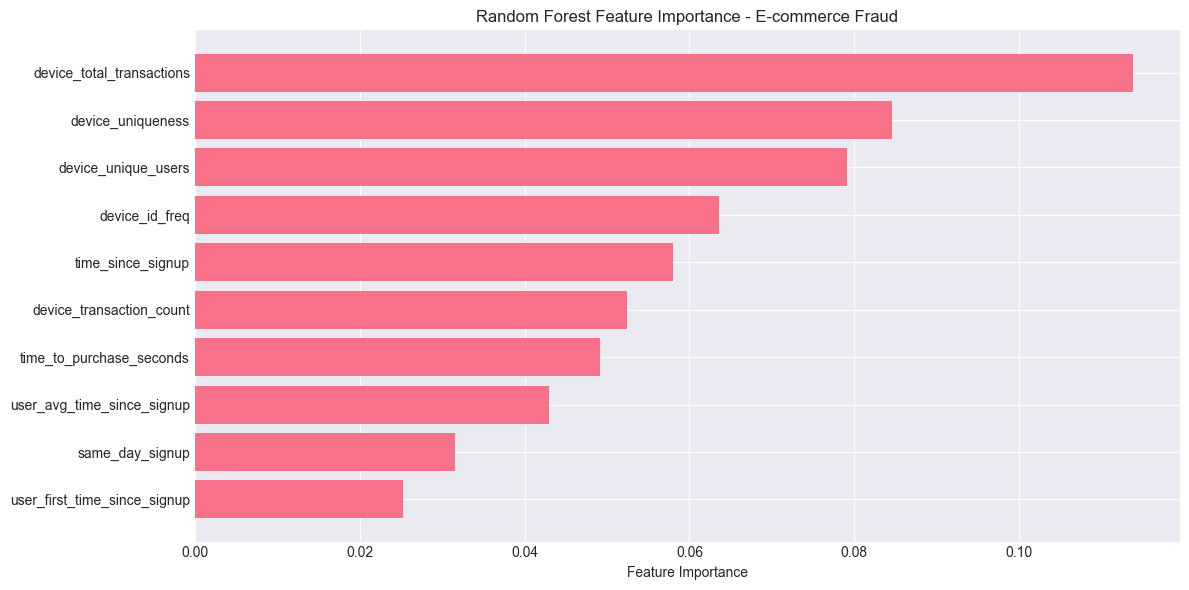


RANDOM FOREST - Credit Card Fraud

Hyperparameter tuning with Grid Search...
  Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
  Best CV score: 1.0000

EVALUATION: Random Forest - Credit Card Fraud

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
       Fraud       0.90      0.84      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy:   0.9996
Precision:  0.9011
Recall:     0.8367
F1-Score:   0.8677
ROC-AUC:    0.9691
PR-AUC:     0.8783

Confusion Matrix:
                Predicted
                Neg    Pos
  Actual Neg   56855       9
          Pos      16      82

Business Metrics:
  False Positive Rate: 0.0002
  False Negative Rate: 0.1633
  Total Cost (FP=1, FN=10): 169

Top 15 F

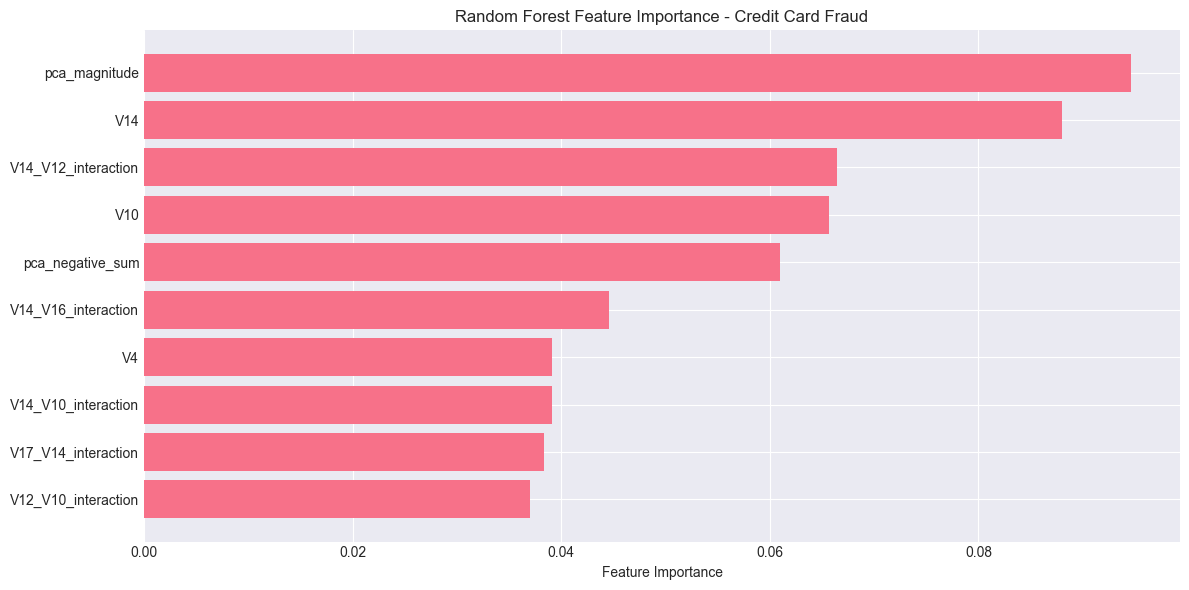

In [32]:
def train_random_forest(X_train, y_train, X_test, y_test, dataset_name, use_smote=True, tune=True):
    """Train and evaluate Random Forest"""
    print(f"\n{'='*80}")
    print(f"RANDOM FOREST - {dataset_name}")
    print(f"{'='*80}")
    
    # Choose training data
    if use_smote and dataset_name == "E-commerce Fraud":
        X_train_use = X_fraud_train_smote
        y_train_use = y_fraud_train_smote
    elif use_smote and dataset_name == "Credit Card Fraud":
        X_train_use = X_credit_train_smote
        y_train_use = y_credit_train_smote
    else:
        X_train_use = X_train
        y_train_use = y_train
    
    if tune:
        print("\nHyperparameter tuning with Grid Search...")
        
        param_grid = {
            'n_estimators': [100],
            'max_depth': [10, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [2],
            'class_weight': ['balanced']
        }
        
        rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
        
        grid_search = GridSearchCV(
            rf_base, param_grid,
            cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X_train_use, y_train_use)
        rf_model = grid_search.best_estimator_
        
        print(f"  Best parameters: {grid_search.best_params_}")
        print(f"  Best CV score: {grid_search.best_score_:.4f}")
        
    else:
        # Use optimized parameters
        rf_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        
        # Cross-validation
        print("\nCross-validation results:")
        cv_scores = cross_val_score(
            rf_model, X_train_use, y_train_use,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring='roc_auc',
            n_jobs=-1
        )
        
        print(f"  ROC-AUC Scores: {cv_scores}")
        print(f"  Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
        
        # Train model
        print("\nTraining model...")
        rf_model.fit(X_train_use, y_train_use)
    
    # Predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Evaluate
    results = evaluate_model(y_test, y_pred, y_pred_proba, 
                           "Random Forest", dataset_name)
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    print(f"\nTop 15 Features by Importance:")
    print(feature_importance.to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(feature_importance.head(10))), 
             feature_importance['importance'].head(10).values[::-1])
    plt.yticks(range(len(feature_importance.head(10))), 
               feature_importance['feature'].head(10).values[::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Random Forest Feature Importance - {dataset_name}')
    plt.tight_layout()
    plt.savefig(f'plots/feature_importance_rf_{dataset_name.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return rf_model, results

print("="*80)
print("TRAINING RANDOM FOREST MODELS")
print("="*80)

# Train for fraud data
rf_fraud_model, rf_fraud_results = train_random_forest(
    X_fraud_train, y_fraud_train, X_fraud_test, y_fraud_test,
    "E-commerce Fraud", use_smote=True, tune=True
)

# Train for credit card data
rf_credit_model, rf_credit_results = train_random_forest(
    X_credit_train, y_credit_train, X_credit_test, y_credit_test,
    "Credit Card Fraud", use_smote=True, tune=True
)

# ## 6. Advanced Model: XGBoost

TRAINING XGBOOST MODELS

XGBOOST - E-commerce Fraud

Hyperparameter tuning with Grid Search...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
  Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
  Best CV score: 0.9526

EVALUATION: XGBoost - E-commerce Fraud

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.96      0.99      0.97     27393
       Fraud       0.81      0.58      0.67      2830

    accuracy                           0.95     30223
   macro avg       0.89      0.78      0.82     30223
weighted avg       0.94      0.95      0.94     30223

Accuracy:   0.9480
Precision:  0.8141
Recall:     0.5756
F1-Score:   0.6744
ROC-AUC:    0.8388
PR-AUC:     0.7105

Confusion Matrix:
                Predicted
                Neg    Pos
  Actual Neg   27021     372
          Pos    1201    1629

Business Metrics:
  False Positive Rate: 0.0136


<Figure size 1200x600 with 0 Axes>

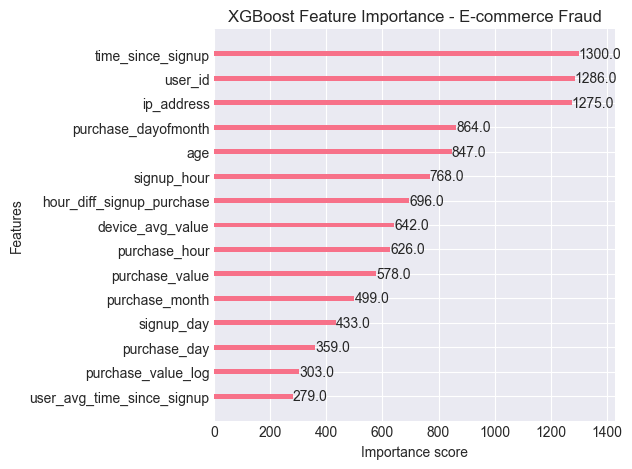


XGBOOST - Credit Card Fraud

Hyperparameter tuning with Grid Search...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
  Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
  Best CV score: 1.0000

EVALUATION: XGBoost - Credit Card Fraud

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
       Fraud       0.87      0.86      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy:   0.9995
Precision:  0.8660
Recall:     0.8571
F1-Score:   0.8615
ROC-AUC:    0.9740
PR-AUC:     0.8696

Confusion Matrix:
                Predicted
                Neg    Pos
  Actual Neg   56851      13
          Pos      14      84

Business Metrics:
  False Positive Rate: 0.0002
  False Negative Rate:

<Figure size 1200x600 with 0 Axes>

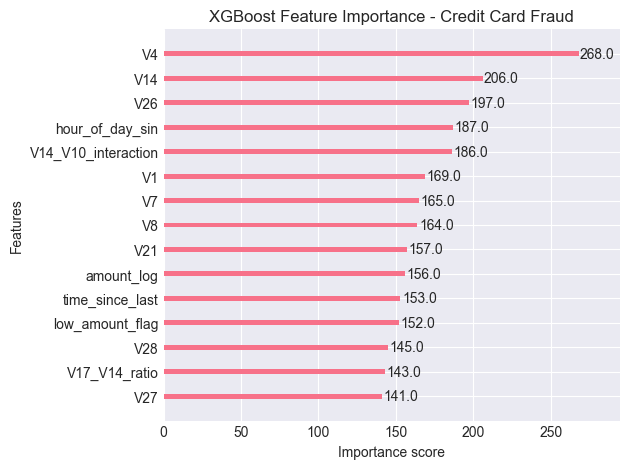

In [30]:
def train_xgboost(X_train, y_train, X_test, y_test, dataset_name, use_smote=True, tune=True):
    """Train and evaluate XGBoost"""
    print(f"\n{'='*80}")
    print(f"XGBOOST - {dataset_name}")
    print(f"{'='*80}")
    
    # Choose training data
    if use_smote and dataset_name == "E-commerce Fraud":
        X_train_use = X_fraud_train_smote
        y_train_use = y_fraud_train_smote
    elif use_smote and dataset_name == "Credit Card Fraud":
        X_train_use = X_credit_train_smote
        y_train_use = y_credit_train_smote
    else:
        X_train_use = X_train
        y_train_use = y_train
    
    # Calculate scale_pos_weight for imbalance
    scale_pos_weight = len(y_train_use[y_train_use == 0]) / len(y_train_use[y_train_use == 1])
    
    if tune:
        print("\nHyperparameter tuning with Grid Search...")
        
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'gamma': [0, 1]
        }
        
        xgb_base = XGBClassifier(
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            eval_metric='aucpr'
        )
        
        grid_search = GridSearchCV(
            xgb_base, param_grid,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train_use, y_train_use)
        xgb_model = grid_search.best_estimator_
        
        print(f"  Best parameters: {grid_search.best_params_}")
        print(f"  Best CV score: {grid_search.best_score_:.4f}")
        
    else:
        # Use optimized parameters
        xgb_model = XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            eval_metric='aucpr'
        )
        
        # Cross-validation
        print("\nCross-validation results:")
        cv_scores = cross_val_score(
            xgb_model, X_train_use, y_train_use,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring='roc_auc',
            n_jobs=-1
        )
        
        print(f"  ROC-AUC Scores: {cv_scores}")
        print(f"  Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
        
        # Train model
        print("\nTraining model...")
        xgb_model.fit(X_train_use, y_train_use)
    
    # Predictions
    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    
    # Evaluate
    results = evaluate_model(y_test, y_pred, y_pred_proba, 
                           "XGBoost", dataset_name)
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    print(f"\nTop 15 Features by Importance:")
    print(feature_importance.to_string(index=False))
    
    # Plot feature importance
    from xgboost import plot_importance
    plt.figure(figsize=(12, 6))
    plot_importance(xgb_model, max_num_features=15)
    plt.title(f'XGBoost Feature Importance - {dataset_name}')
    plt.tight_layout()
    plt.savefig(f'plots/feature_importance_xgb_{dataset_name.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return xgb_model, results

print("="*80)
print("TRAINING XGBOOST MODELS")
print("="*80)

# Train for fraud data
xgb_fraud_model, xgb_fraud_results = train_xgboost(
    X_fraud_train, y_fraud_train, X_fraud_test, y_fraud_test,
    "E-commerce Fraud", use_smote=True, tune=True
)

# Train for credit card data
xgb_credit_model, xgb_credit_results = train_xgboost(
    X_credit_train, y_credit_train, X_credit_test, y_credit_test,
    "Credit Card Fraud", use_smote=True, tune=True
)


# ## 7. Model Comparison and Selection

MODEL COMPARISON AND SELECTION

MODEL COMPARISON - E-commerce Fraud

Detailed Comparison:
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  PR-AUC  Total Cost  FP Rate  FN Rate
Logistic Regression    0.9047     0.4939  0.7166    0.5848   0.8355  0.6945       10098   0.0759   0.2834
      Random Forest    0.9551     0.9718  0.5357    0.6907   0.8434  0.7144       13184   0.0016   0.4643
            XGBoost    0.9480     0.8141  0.5756    0.6744   0.8388  0.7105       12382   0.0136   0.4244


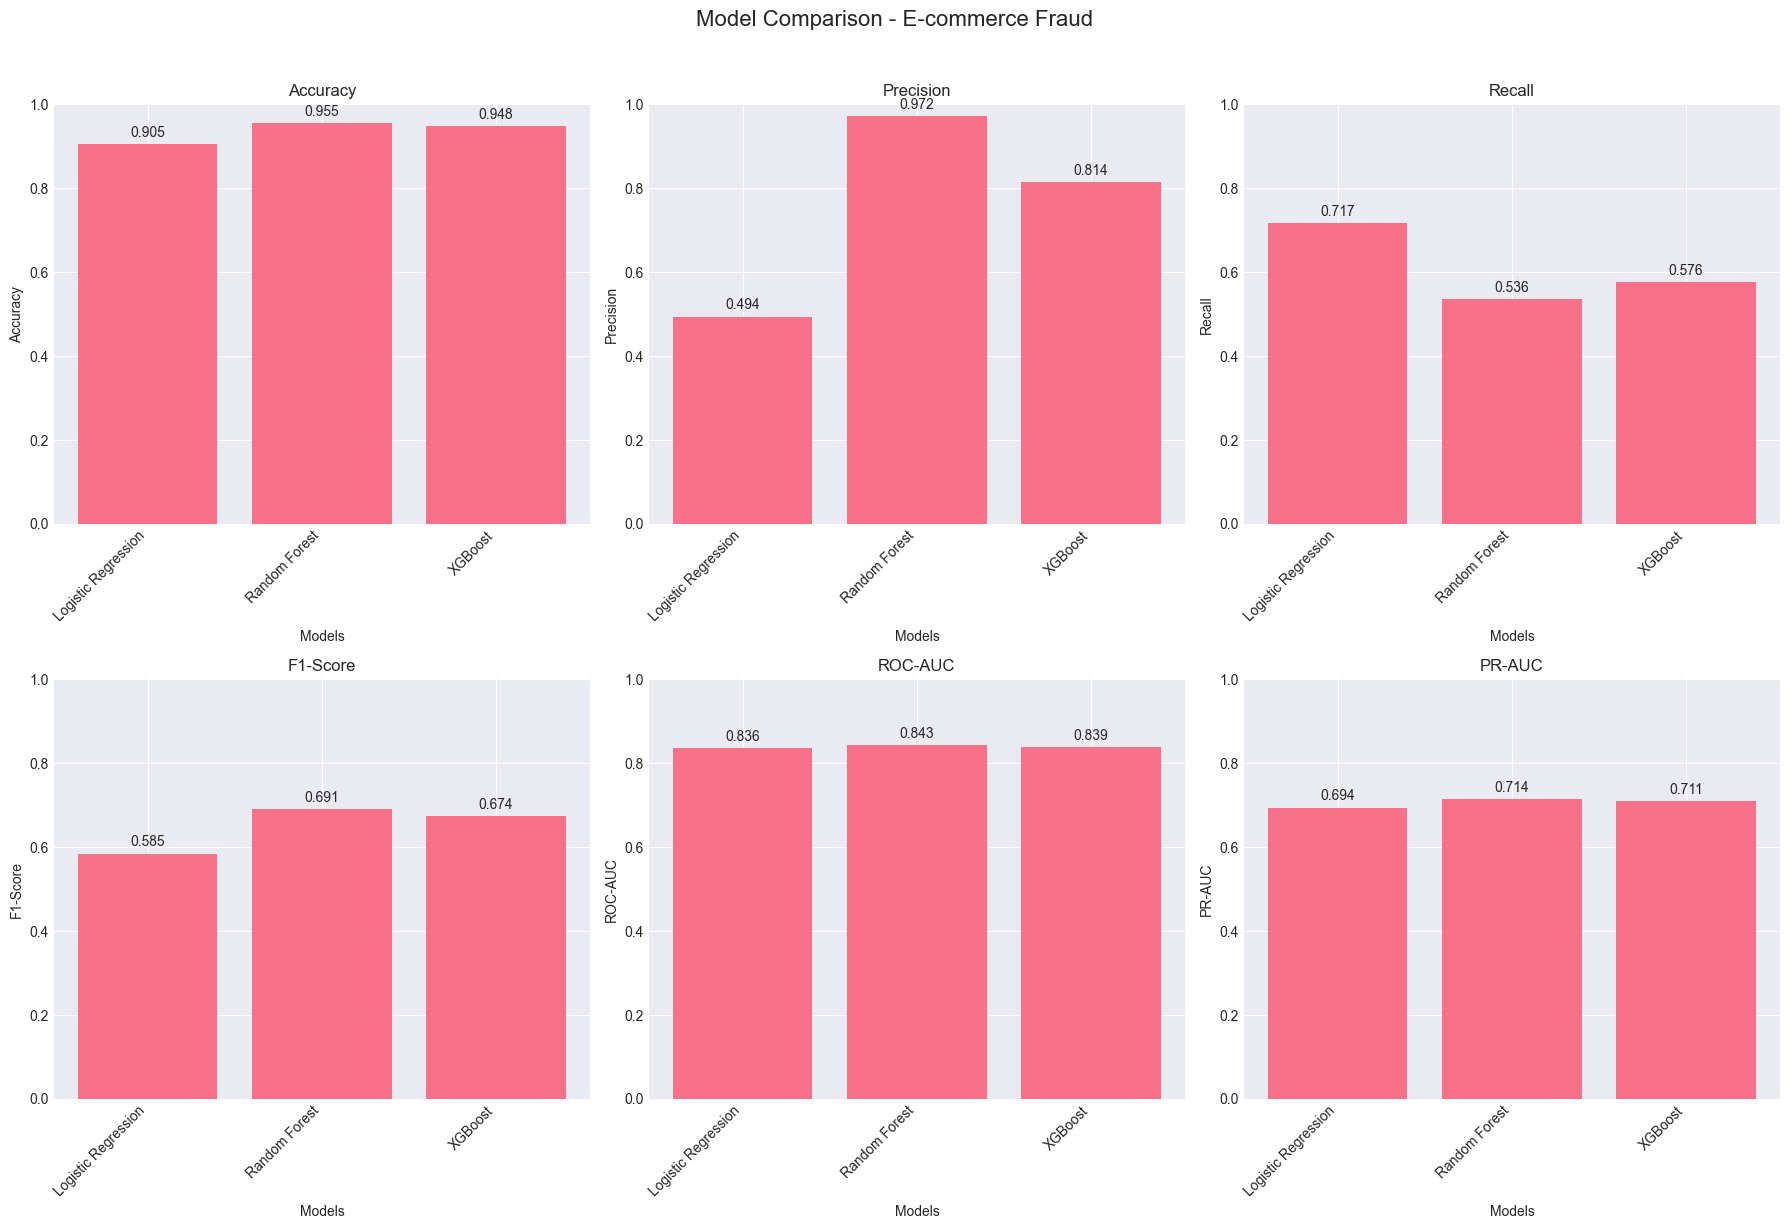

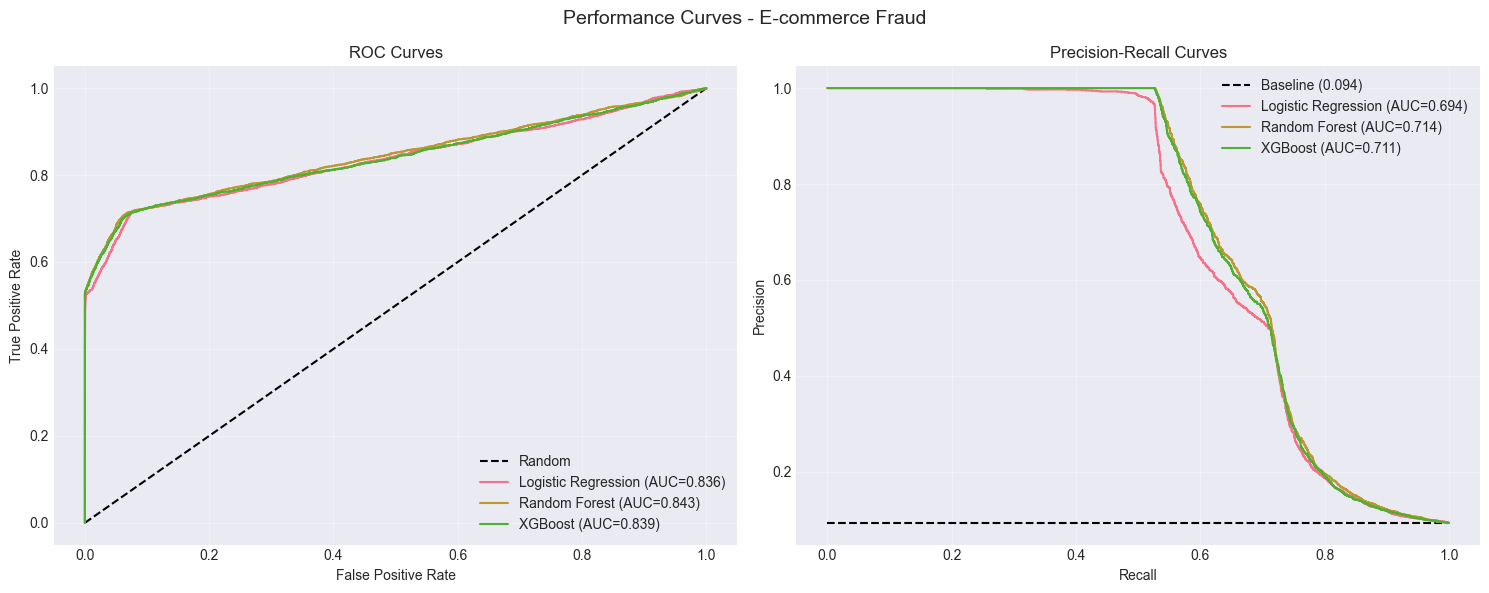


MODEL SELECTION - E-commerce Fraud

Weighted Scores:
  Logistic Regression: 0.6320
  Random Forest: 0.5862
  XGBoost: 0.5997

Selected Best Model: Logistic Regression
  PR-AUC: 0.6945
  Recall: 0.7166
  F1-Score: 0.5848
  Total Cost: 10098

MODEL COMPARISON - Credit Card Fraud

Detailed Comparison:
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  PR-AUC  Total Cost  FP Rate  FN Rate
Logistic Regression    0.9796     0.0704  0.8878    0.1304   0.9744  0.7297        1259   0.0202   0.1122
      Random Forest    0.9996     0.9011  0.8367    0.8677   0.9691  0.8783         169   0.0002   0.1633
            XGBoost    0.9995     0.8660  0.8571    0.8615   0.9740  0.8696         153   0.0002   0.1429


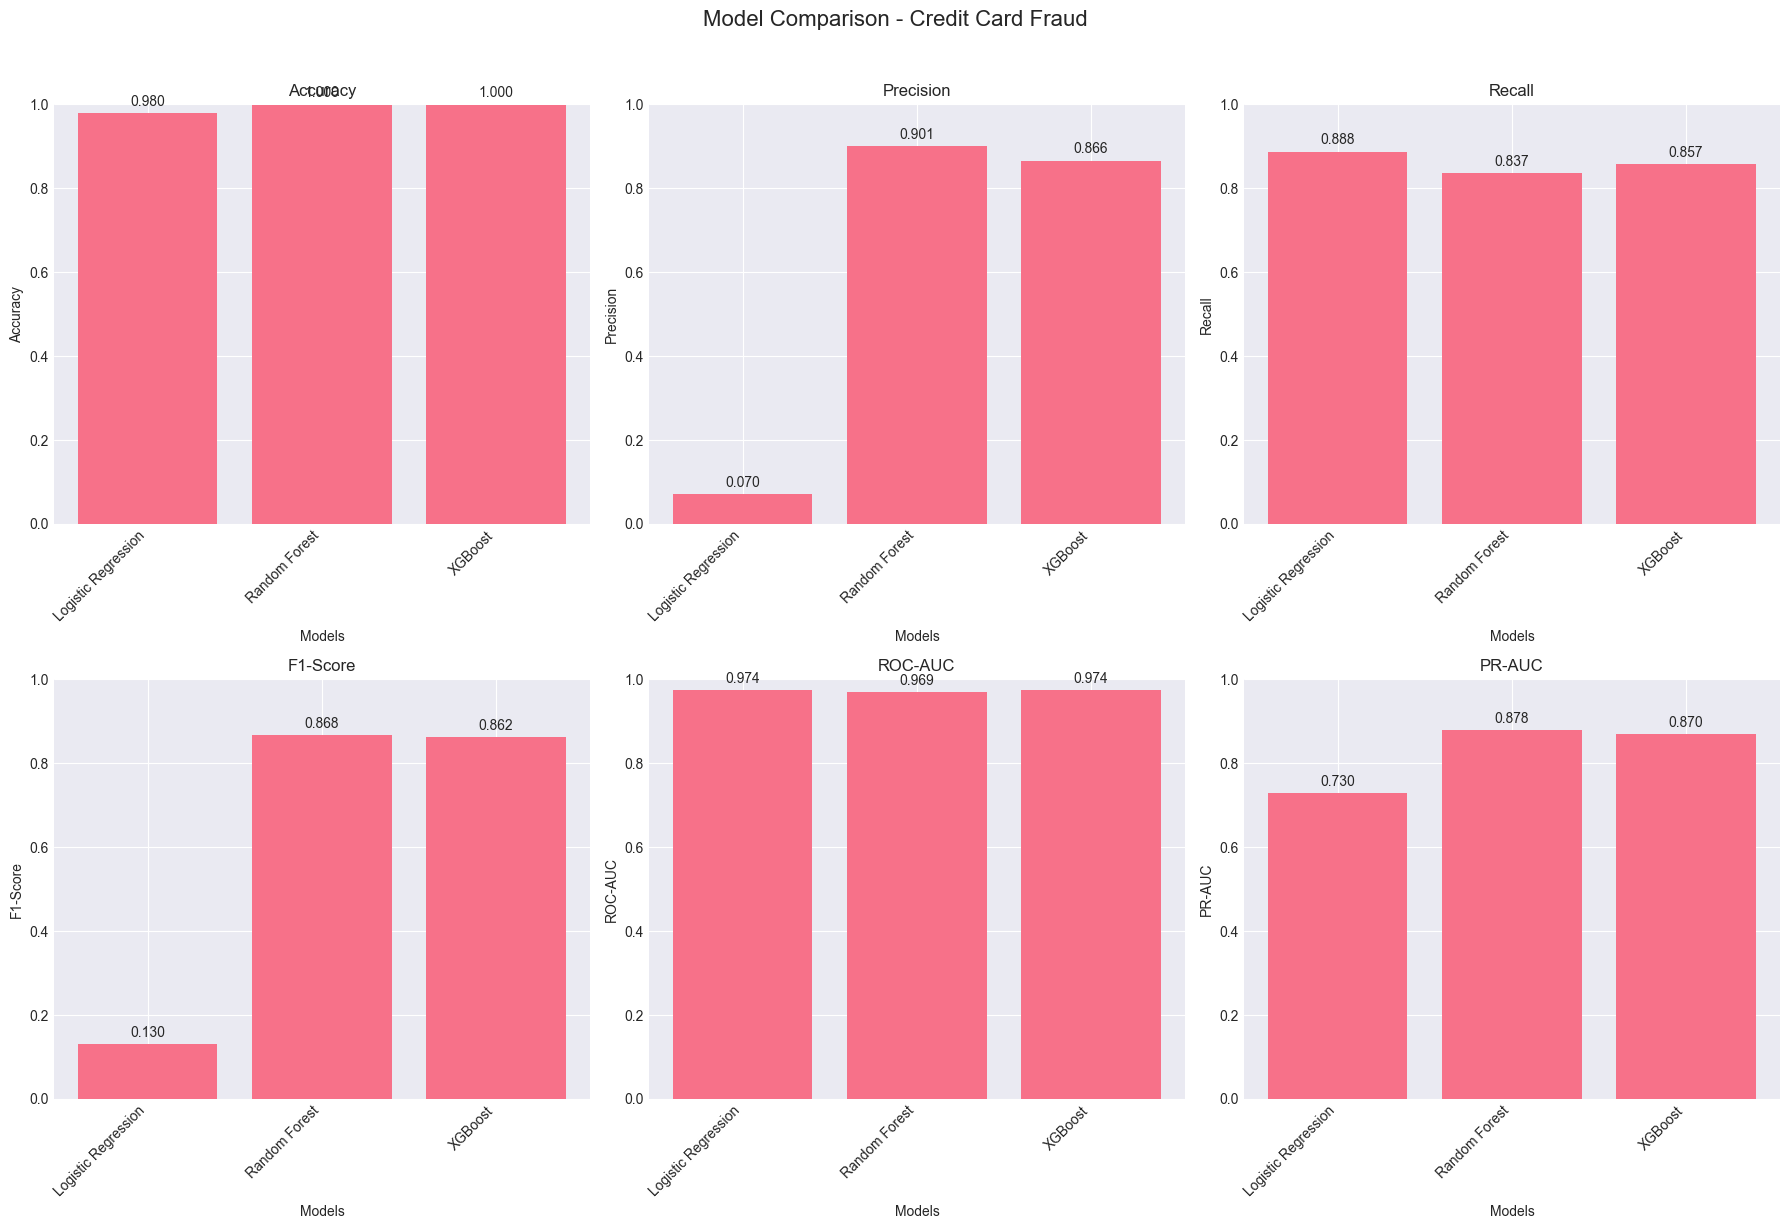

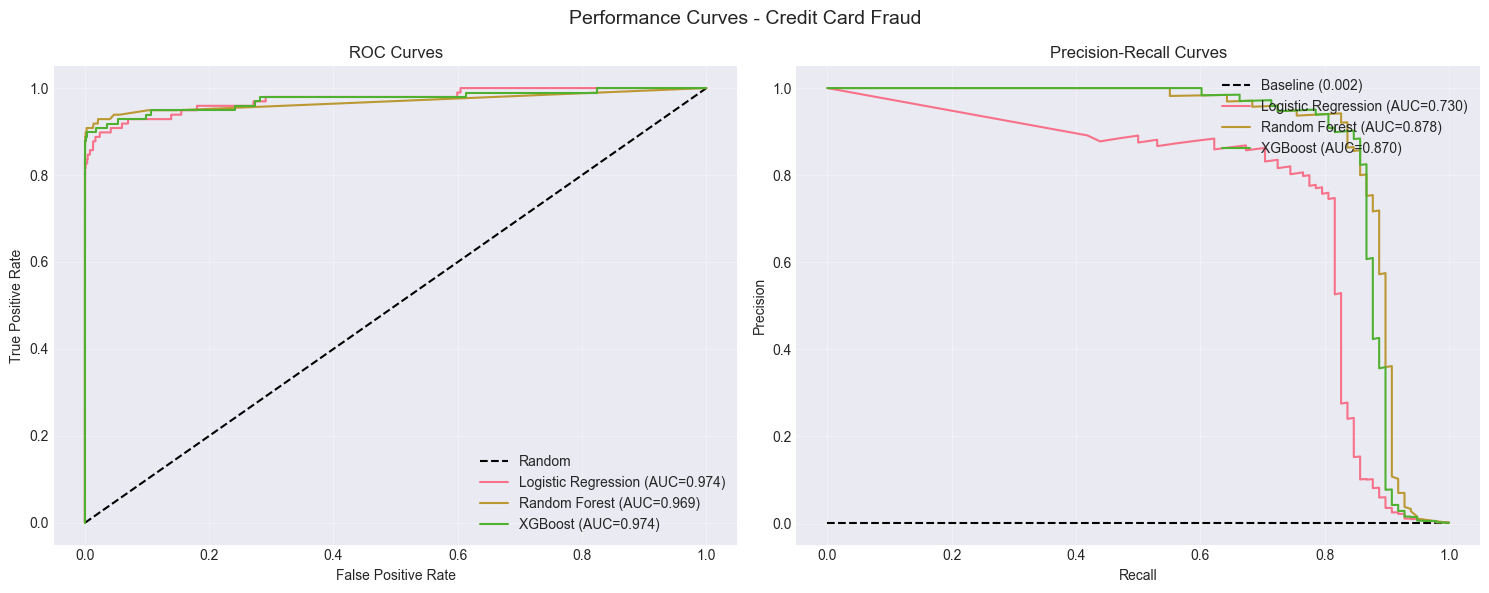


MODEL SELECTION - Credit Card Fraud

Weighted Scores:
  Logistic Regression: 0.5649
  Random Forest: 0.8761
  XGBoost: 0.8792

Selected Best Model: XGBoost
  PR-AUC: 0.8696
  Recall: 0.8571
  F1-Score: 0.8615
  Total Cost: 153


In [43]:
def compare_and_select_models(models_dict, results_dict, dataset_name):
    """Compare models and select the best one"""
    print(f"\n{'='*80}")
    print(f"MODEL COMPARISON - {dataset_name}")
    print(f"{'='*80}")
    
    # Create comparison dataframe
    comparison_data = []
    
    for model_name, results in results_dict.items():
        row = {
            'Model': model_name,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score': results['f1_score'],
            'ROC-AUC': results.get('roc_auc', 0),
            'PR-AUC': results.get('pr_auc', 0),
            'Total Cost': results['total_cost'],
            'FP Rate': results['false_positive_rate'],
            'FN Rate': results['false_negative_rate']
        }
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\nDetailed Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Visual comparison
    plot_model_comparison(results_dict, dataset_name)
    
    # Plot curves
    plot_roc_pr_curves(models_dict, 
                       X_fraud_test if dataset_name == "E-commerce Fraud" else X_credit_test,
                       y_fraud_test if dataset_name == "E-commerce Fraud" else y_credit_test,
                       dataset_name)
    
    # Select best model based on weighted criteria
    print(f"\n{'='*80}")
    print(f"MODEL SELECTION - {dataset_name}")
    print(f"{'='*80}")
    
    # Define weights for business priorities
    weights = {
        'PR-AUC': 0.30,  # Most important for imbalanced data
        'Recall': 0.25,  # Important to catch fraud
        'F1-Score': 0.20,  # Balance precision and recall
        'Total Cost': 0.15,  # Business impact
        'FP Rate': 0.10  # Customer experience
    }
    
    # Calculate weighted scores
    weighted_scores = {}
    
    for model_name, results in results_dict.items():
        score = (
            results.get('pr_auc', 0) * weights['PR-AUC'] +
            results['recall'] * weights['Recall'] +
            results['f1_score'] * weights['F1-Score'] +
            (1 - results['total_cost'] / max(comparison_df['Total Cost'])) * weights['Total Cost'] +
            (1 - results['false_positive_rate']) * weights['FP Rate']
        )
        weighted_scores[model_name] = score
    
    # Select best model
    best_model_name = max(weighted_scores, key=weighted_scores.get)
    best_model = models_dict[best_model_name]
    
    print(f"\nWeighted Scores:")
    for model_name, score in weighted_scores.items():
        print(f"  {model_name}: {score:.4f}")
    
    print(f"\nSelected Best Model: {best_model_name}")
    print(f"  PR-AUC: {results_dict[best_model_name].get('pr_auc', 0):.4f}")
    print(f"  Recall: {results_dict[best_model_name]['recall']:.4f}")
    print(f"  F1-Score: {results_dict[best_model_name]['f1_score']:.4f}")
    print(f"  Total Cost: {results_dict[best_model_name]['total_cost']:.0f}")
    
    return best_model_name, best_model, comparison_df

# Compare models for both datasets
print("="*80)
print("MODEL COMPARISON AND SELECTION")
print("="*80)

# E-commerce models
fraud_models = {
    "Logistic Regression": lr_fraud_model,
    "Random Forest": rf_fraud_model,
    "XGBoost": xgb_fraud_model
}

fraud_results = {
    "Logistic Regression": lr_fraud_results,
    "Random Forest": rf_fraud_results,
    "XGBoost": xgb_fraud_results
}

best_fraud_name, best_fraud_model, fraud_comparison = compare_and_select_models(
    fraud_models, fraud_results, "E-commerce Fraud"
)

# Credit card models
credit_models = {
    "Logistic Regression": lr_credit_model,
    "Random Forest": rf_credit_model,
    "XGBoost": xgb_credit_model
}

credit_results = {
    "Logistic Regression": lr_credit_results,
    "Random Forest": rf_credit_results,
    "XGBoost": xgb_credit_results
}

best_credit_name, best_credit_model, credit_comparison = compare_and_select_models(
    credit_models, credit_results, "Credit Card Fraud"
)

# ## 8. Threshold Optimization

THRESHOLD OPTIMIZATION

THRESHOLD OPTIMIZATION - Logistic Regression


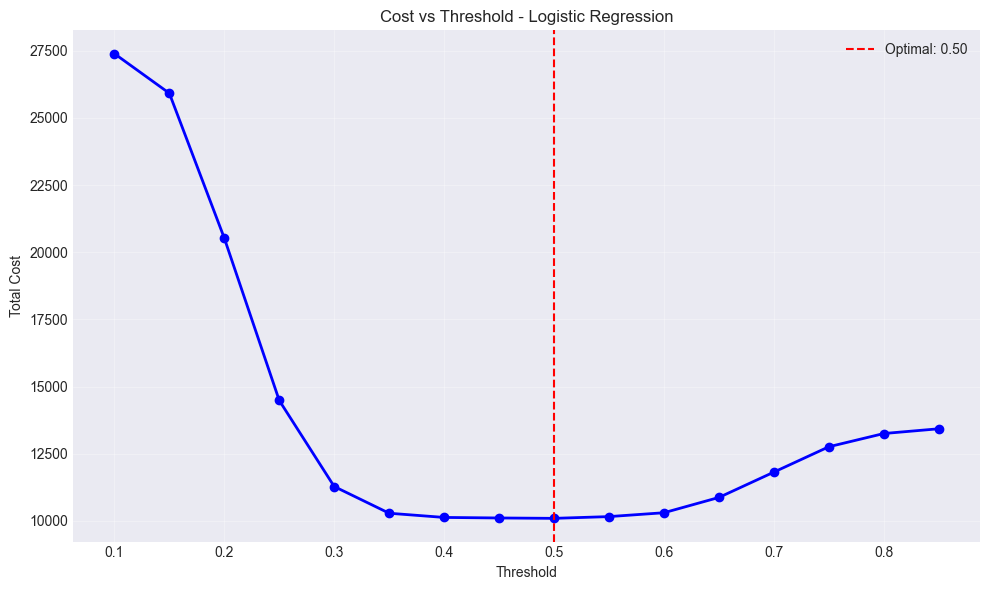


EVALUATION: Logistic Regression (Threshold=0.50) - E-commerce Fraud

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.97      0.92      0.95     27393
       Fraud       0.49      0.72      0.58      2830

    accuracy                           0.90     30223
   macro avg       0.73      0.82      0.77     30223
weighted avg       0.92      0.90      0.91     30223

Accuracy:   0.9047
Precision:  0.4939
Recall:     0.7166
F1-Score:   0.5848
ROC-AUC:    0.8355
PR-AUC:     0.6945

Confusion Matrix:
                Predicted
                Neg    Pos
  Actual Neg   25315    2078
          Pos     802    2028

Business Metrics:
  False Positive Rate: 0.0759
  False Negative Rate: 0.2834
  Total Cost (FP=1, FN=10): 10098

Optimal Threshold: 0.500
Cost Reduction: 0.0 units

THRESHOLD OPTIMIZATION - XGBoost


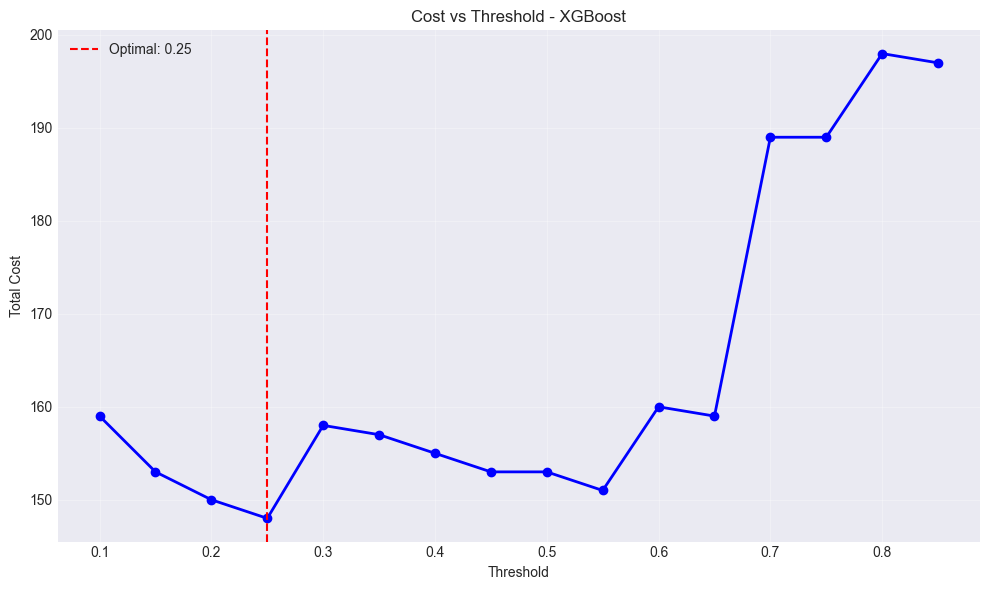


EVALUATION: XGBoost (Threshold=0.25) - Credit Card Fraud

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
       Fraud       0.83      0.87      0.85        98

    accuracy                           1.00     56962
   macro avg       0.91      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy:   0.9995
Precision:  0.8252
Recall:     0.8673
F1-Score:   0.8458
ROC-AUC:    0.9740
PR-AUC:     0.8696

Confusion Matrix:
                Predicted
                Neg    Pos
  Actual Neg   56846      18
          Pos      13      85

Business Metrics:
  False Positive Rate: 0.0003
  False Negative Rate: 0.1327
  Total Cost (FP=1, FN=10): 148

Optimal Threshold: 0.250
Cost Reduction: 5.0 units


In [44]:
def optimize_threshold(model, X_test, y_test, model_name, dataset_name):
    """Optimize prediction threshold based on business costs"""
    print(f"\n{'='*80}")
    print(f"THRESHOLD OPTIMIZATION - {model_name}")
    print(f"{'='*80}")
    
    # Get predicted probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Define costs
    fp_cost = 1  # Customer friction
    fn_cost = 10  # Missed fraud
    
    # Try different thresholds
    thresholds = np.arange(0.1, 0.9, 0.05)
    costs = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        total_cost = (fp * fp_cost) + (fn * fn_cost)
        costs.append(total_cost)
    
    # Find optimal threshold
    optimal_idx = np.argmin(costs)
    optimal_threshold = thresholds[optimal_idx]
    
    # Plot cost vs threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, costs, 'b-', marker='o', linewidth=2)
    plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
                label=f'Optimal: {optimal_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Total Cost')
    plt.title(f'Cost vs Threshold - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'plots/threshold_optimization_{model_name.replace(" ", "_")}_{dataset_name.replace(" ", "_")}.png',
               dpi=300, bbox_inches='tight')
    plt.show()
    
    # Evaluate with optimal threshold
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    optimal_results = evaluate_model(y_test, y_pred_optimal, y_pred_proba,
                                   f"{model_name} (Threshold={optimal_threshold:.2f})",
                                   dataset_name)
    
    print(f"\nOptimal Threshold: {optimal_threshold:.3f}")
    print(f"Cost Reduction: {costs[len(costs)//2] - costs[optimal_idx]:.1f} units")
    
    return optimal_threshold, optimal_results

# Optimize thresholds for best models
print("="*80)
print("THRESHOLD OPTIMIZATION")
print("="*80)

# For fraud best model
fraud_optimal_threshold, fraud_optimal_results = optimize_threshold(
    best_fraud_model, X_fraud_test, y_fraud_test,
    best_fraud_name, "E-commerce Fraud"
)

# For credit best model
credit_optimal_threshold, credit_optimal_results = optimize_threshold(
    best_credit_model, X_credit_test, y_credit_test,
    best_credit_name, "Credit Card Fraud"
)

# ## 9. Cross-Validation Analysis

CROSS-VALIDATION ANALYSIS

E-commerce Fraud Model:

CROSS-VALIDATION - Logistic Regression

ROC_AUC:
  Scores: [0.91446663 0.92342335 0.90311599 0.90501177 0.90981861]
  Mean: 0.9112
  Std: 0.0073

AVERAGE_PRECISION:
  Scores: [0.86476789 0.884183   0.84915929 0.85171766 0.85524256]
  Mean: 0.8610
  Std: 0.0127

F1:
  Scores: [0.77511038 0.79797773 0.75380547 0.76025037 0.75527933]
  Mean: 0.7685
  Std: 0.0166

RECALL:
  Scores: [0.77693265 0.8076338  0.7293597  0.74737279 0.73935288]
  Mean: 0.7601
  Std: 0.0286

PRECISION:
  Scores: [0.77329663 0.78854982 0.77994676 0.7735795  0.77190703]
  Mean: 0.7775
  Std: 0.0062


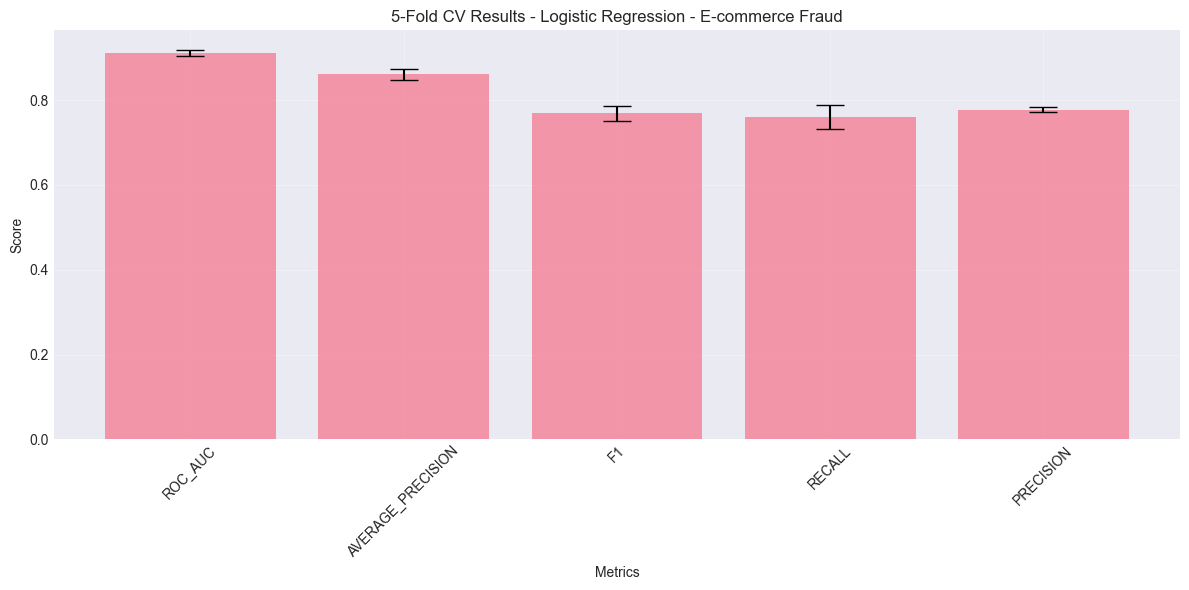


Credit Card Fraud Model:

CROSS-VALIDATION - XGBoost

ROC_AUC:
  Scores: [0.99999522 0.99999998 0.99999883 0.99999258 0.99999824]
  Mean: 1.0000
  Std: 0.0000

AVERAGE_PRECISION:
  Scores: [0.99998471 0.99999992 0.99999641 0.99997593 0.99999444]
  Mean: 1.0000
  Std: 0.0000

F1:
  Scores: [0.99970031 0.99983349 0.99966704 0.99943411 0.9997336 ]
  Mean: 0.9997
  Std: 0.0001

RECALL:
  Scores: [1. 1. 1. 1. 1.]
  Mean: 1.0000
  Std: 0.0000

PRECISION:
  Scores: [0.9994008  0.99966704 0.99933431 0.99886885 0.99946734]
  Mean: 0.9993
  Std: 0.0003


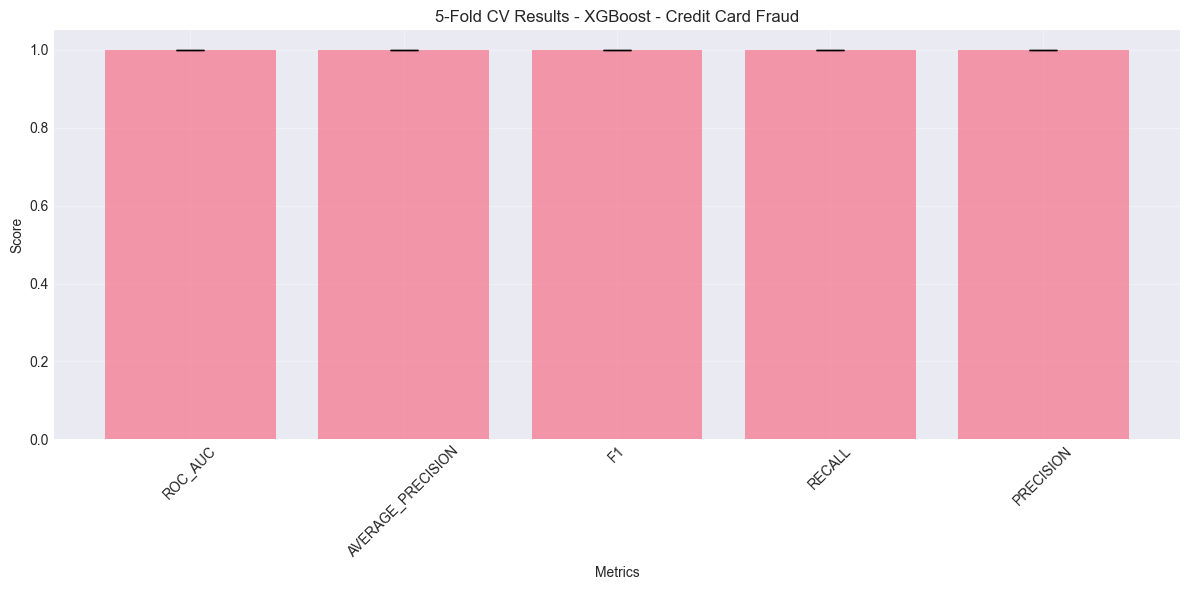

In [45]:
def perform_cross_validation(model, X, y, model_name, dataset_name):
    """Perform stratified cross-validation"""
    print(f"\n{'='*80}")
    print(f"CROSS-VALIDATION - {model_name}")
    print(f"{'='*80}")
    
    # Define metrics
    scoring = {
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',
        'f1': 'f1',
        'recall': 'recall',
        'precision': 'precision'
    }
    
    cv_results = {}
    
    for metric_name, metric_scorer in scoring.items():
        scores = cross_val_score(
            model, X, y,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring=metric_scorer,
            n_jobs=-1
        )
        cv_results[metric_name] = scores
        
        print(f"\n{metric_name.upper()}:")
        print(f"  Scores: {scores}")
        print(f"  Mean: {scores.mean():.4f}")
        print(f"  Std: {scores.std():.4f}")
    
    # Plot CV results
    fig, ax = plt.subplots(figsize=(12, 6))
    
    metrics = list(cv_results.keys())
    x_pos = np.arange(len(metrics))
    
    means = [cv_results[m].mean() for m in metrics]
    stds = [cv_results[m].std() for m in metrics]
    
    bars = ax.bar(x_pos, means, yerr=stds, capsize=10, alpha=0.7)
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title(f'5-Fold CV Results - {model_name} - {dataset_name}')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([m.upper() for m in metrics], rotation=45)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'plots/cv_results_{model_name.replace(" ", "_")}_{dataset_name.replace(" ", "_")}.png',
               dpi=300, bbox_inches='tight')
    plt.show()
    
    return cv_results

# Perform CV for best models
print("="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)

# Use resampled data for CV
print("\nE-commerce Fraud Model:")
fraud_cv_results = perform_cross_validation(
    best_fraud_model, X_fraud_train_smote, y_fraud_train_smote,
    best_fraud_name, "E-commerce Fraud"
)

print("\nCredit Card Fraud Model:")
credit_cv_results = perform_cross_validation(
    best_credit_model, X_credit_train_smote, y_credit_train_smote,
    best_credit_name, "Credit Card Fraud"
)


# ## 10. Save Models and Results

In [49]:
def save_models_and_results():
    """Save all models and results"""
    import os
    import json
    import numpy as np
    
    # Create directories
    os.makedirs('models', exist_ok=True)
    os.makedirs('models/artifacts', exist_ok=True)
    
    print("Saving models and artifacts...")
    
    # Save models
    joblib.dump(lr_fraud_model, 'models/logistic_regression_fraud.pkl')
    joblib.dump(rf_fraud_model, 'models/random_forest_fraud.pkl')
    joblib.dump(xgb_fraud_model, 'models/xgboost_fraud.pkl')
    joblib.dump(best_fraud_model, 'models/best_model_fraud.pkl')
    
    joblib.dump(lr_credit_model, 'models/logistic_regression_credit.pkl')
    joblib.dump(rf_credit_model, 'models/random_forest_credit.pkl')
    joblib.dump(xgb_credit_model, 'models/xgboost_credit.pkl')
    joblib.dump(best_credit_model, 'models/best_model_credit.pkl')
    
    # Save thresholds
    thresholds = {
        'fraud_optimal_threshold': fraud_optimal_threshold,
        'credit_optimal_threshold': credit_optimal_threshold
    }
    joblib.dump(thresholds, 'models/optimal_thresholds.pkl')
    
    # Helper function to convert numpy types to Python types
    def make_serializable(obj):
        """Convert numpy objects to Python native types for JSON serialization"""
        if isinstance(obj, np.ndarray):
            if obj.size == 1:
                return float(obj.item()) if obj.dtype.kind in 'fc' else int(obj.item())
            else:
                return obj.tolist()
        elif isinstance(obj, np.generic):
            return float(obj) if obj.dtype.kind in 'fc' else int(obj)
        elif isinstance(obj, (int, float, str, bool)) or obj is None:
            return obj
        elif isinstance(obj, dict):
            return {k: make_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [make_serializable(item) for item in obj]
        else:
            try:
                return float(obj)
            except:
                return str(obj)
    
    # Convert performance dictionaries
    fraud_perf = {k: make_serializable(v) for k, v in fraud_optimal_results.items()}
    credit_perf = {k: make_serializable(v) for k, v in credit_optimal_results.items()}
    
    # Convert CV results
    fraud_cv_serializable = {}
    if fraud_cv_results is not None:
        fraud_cv_serializable = {k: make_serializable(v) for k, v in fraud_cv_results.items()}
    
    credit_cv_serializable = {}
    if credit_cv_results is not None:
        credit_cv_serializable = {k: make_serializable(v) for k, v in credit_cv_results.items()}
    
    # Save results
    fraud_summary = {
        'best_model': best_fraud_name,
        'optimal_threshold': make_serializable(fraud_optimal_threshold),
        'performance': fraud_perf,
        'cv_results': fraud_cv_serializable
    }
    
    credit_summary = {
        'best_model': best_credit_name,
        'optimal_threshold': make_serializable(credit_optimal_threshold),
        'performance': credit_perf,
        'cv_results': credit_cv_serializable
    }
    
    with open('models/artifacts/fraud_summary.json', 'w') as f:
        json.dump(fraud_summary, f, indent=2)
    
    with open('models/artifacts/credit_summary.json', 'w') as f:
        json.dump(credit_summary, f, indent=2)
    
    # Save comparison dataframes
    fraud_comparison.to_csv('models/artifacts/fraud_model_comparison.csv', index=False)
    credit_comparison.to_csv('models/artifacts/credit_model_comparison.csv', index=False)
    
    print("✓ All models and artifacts saved successfully!")
    print("\nSaved files:")
    print("  models/logistic_regression_*.pkl")
    print("  models/random_forest_*.pkl")
    print("  models/xgboost_*.pkl")
    print("  models/best_model_*.pkl")
    print("  models/optimal_thresholds.pkl")
    print("  models/artifacts/*.json")
    print("  models/artifacts/*.csv")

print("="*80)
print("SAVING MODELS AND RESULTS")
print("="*80)

save_models_and_results()

SAVING MODELS AND RESULTS
Saving models and artifacts...
✓ All models and artifacts saved successfully!

Saved files:
  models/logistic_regression_*.pkl
  models/random_forest_*.pkl
  models/xgboost_*.pkl
  models/best_model_*.pkl
  models/optimal_thresholds.pkl
  models/artifacts/*.json
  models/artifacts/*.csv


# ## 11. Summary and Next Steps

In [52]:
def create_modeling_summary():
    """Create final modeling summary"""
    import numpy as np
    import os
    
    # Helper function to convert numpy types to Python native types
    def convert_to_native(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert_to_native(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_native(item) for item in obj]
        else:
            return obj
    
    summary = {
        "project_status": "Modeling completed successfully",
        "datasets_modeled": ["E-commerce Fraud", "Credit Card Fraud"],
        "models_trained": {
            "ecommerce": {
                "logistic_regression": "Trained with class weights",
                "random_forest": "Tuned with Grid Search",
                "xgboost": "Tuned with Grid Search",
                "best_model": best_fraud_name,
                "best_threshold": float(fraud_optimal_threshold) if hasattr(fraud_optimal_threshold, '__float__') else fraud_optimal_threshold
            },
            "creditcard": {
                "logistic_regression": "Trained with class weights",
                "random_forest": "Tuned with Grid Search",
                "xgboost": "Tuned with Grid Search",
                "best_model": best_credit_name,
                "best_threshold": float(credit_optimal_threshold) if hasattr(credit_optimal_threshold, '__float__') else credit_optimal_threshold
            }
        },
        "key_results": {
            "ecommerce_performance": {
                "pr_auc": float(fraud_optimal_results.get('pr_auc', 0)) if hasattr(fraud_optimal_results.get('pr_auc', 0), '__float__') else fraud_optimal_results.get('pr_auc', 0),
                "recall": float(fraud_optimal_results['recall']) if hasattr(fraud_optimal_results['recall'], '__float__') else fraud_optimal_results['recall'],
                "f1_score": float(fraud_optimal_results['f1_score']) if hasattr(fraud_optimal_results['f1_score'], '__float__') else fraud_optimal_results['f1_score'],
                "total_cost": int(fraud_optimal_results['total_cost']) if hasattr(fraud_optimal_results['total_cost'], '__int__') else fraud_optimal_results['total_cost']
            },
            "creditcard_performance": {
                "pr_auc": float(credit_optimal_results.get('pr_auc', 0)) if hasattr(credit_optimal_results.get('pr_auc', 0), '__float__') else credit_optimal_results.get('pr_auc', 0),
                "recall": float(credit_optimal_results['recall']) if hasattr(credit_optimal_results['recall'], '__float__') else credit_optimal_results['recall'],
                "f1_score": float(credit_optimal_results['f1_score']) if hasattr(credit_optimal_results['f1_score'], '__float__') else credit_optimal_results['f1_score'],
                "total_cost": int(credit_optimal_results['total_cost']) if hasattr(credit_optimal_results['total_cost'], '__int__') else credit_optimal_results['total_cost']
            }
        },
        "methodologies_applied": [
            "Stratified train-test split (80-20)",
            "SMOTE for class imbalance handling",
            "5-fold stratified cross-validation",
            "Grid Search for hyperparameter tuning",
            "Cost-based threshold optimization",
            "Business-weighted model selection"
        ],
        "next_steps": [
            "Proceed to shap-explainability.ipynb for model interpretation",
            "Analyze feature importance with SHAP",
            "Generate business recommendations",
            "Prepare deployment pipeline"
        ]
    }
    
    # Convert all numpy types in the summary
    summary = convert_to_native(summary)
    
    # Print summary
    print("="*80)
    print("MODELING COMPLETION SUMMARY")
    print("="*80)
    
    for section, content in summary.items():
        print(f"\n{section.replace('_', ' ').title()}:")
        print("-" * 40)
        
        if isinstance(content, dict):
            for key, value in content.items():
                if isinstance(value, dict):
                    print(f"\n  {key.replace('_', ' ').title()}:")
                    for k, v in value.items():
                        print(f"    {k}: {v}")
                elif isinstance(value, list):
                    print(f"  {key.replace('_', ' ').title()}:")
                    for item in value:
                        print(f"    • {item}")
                else:
                    print(f"  {key.replace('_', ' ').title()}: {value}")
        elif isinstance(content, list):
            for item in content:
                print(f"  • {item}")
    
    # Create directory if it doesn't exist
    os.makedirs('notebooks', exist_ok=True)
    
    # Save summary
    with open('notebooks/modeling_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\n✓ Summary saved to: notebooks/modeling_summary.json")
    
    return summary

print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

modeling_summary = create_modeling_summary()

print("\n" + "="*80)
print("MODELING COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nNext step: Proceed to shap-explainability.ipynb")
print("All models are saved and ready for interpretation.")


FINAL SUMMARY
MODELING COMPLETION SUMMARY

Project Status:
----------------------------------------

Datasets Modeled:
----------------------------------------
  • E-commerce Fraud
  • Credit Card Fraud

Models Trained:
----------------------------------------

  Ecommerce:
    logistic_regression: Trained with class weights
    random_forest: Tuned with Grid Search
    xgboost: Tuned with Grid Search
    best_model: Logistic Regression
    best_threshold: 0.5000000000000001

  Creditcard:
    logistic_regression: Trained with class weights
    random_forest: Tuned with Grid Search
    xgboost: Tuned with Grid Search
    best_model: XGBoost
    best_threshold: 0.25000000000000006

Key Results:
----------------------------------------

  Ecommerce Performance:
    pr_auc: 0.6944542706728376
    recall: 0.7166077738515901
    f1_score: 0.5847750865051903
    total_cost: 10098

  Creditcard Performance:
    pr_auc: 0.8695856180023502
    recall: 0.8673469387755102
    f1_score: 0.8457711